In [4]:
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

filePath = "/home/naymeeysh/Desktop/UG4-2/BRSM/Project/OptimalQuittingExperiment/full_experiment_data.pkl"

import pandas as pd
data = pd.read_pickle(filePath)


363200
363200
28454
334746
28454


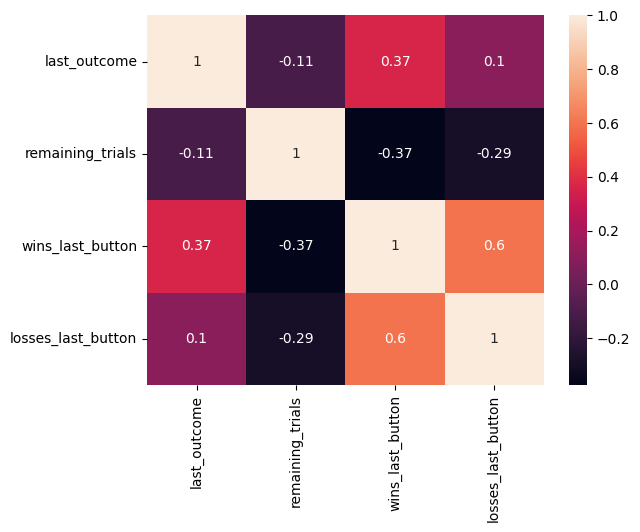

In [5]:
# Initialize a list to store the features and labels
features = []
labels = []

k = 0

# Process data for each person
for person_data in data['press_data']:
    # Initialize variables to count wins and losses in the last button
    wins_last_button = 0
    losses_last_button = 0
    
    # Store the current button number and outcome
    current_button = person_data[0]['button_number']
    last_outcome = 0
    
    # Iterate through the trials of the person
    for i in range(len(person_data)):
        trial = person_data[i]
        k+=1
        
        # Check if there is a change in button_number
        if trial['button_number'] != current_button:
            # Calculate remaining trials
            remaining_trials = len(person_data) - i
            
            # Calculate features X: last outcome, remaining trials, wins in last button, losses in last button
            features.append([last_outcome, remaining_trials, wins_last_button, losses_last_button])
            
            # Target variable Y: change in button_number
            labels.append(1)
            
            # Reset win/loss counters and current button
            wins_last_button = 0
            losses_last_button = 0
            current_button = trial['button_number']
        else:
            # Calculate wins and losses in the current button
            if trial['outcome'] == 1:
                wins_last_button += 1
            else:
                losses_last_button += 1
            
            remaining_trials = len(person_data) - i

            features.append([last_outcome, remaining_trials, wins_last_button, losses_last_button])

            labels.append(0)
        
        # Store the last outcome
        last_outcome = trial['outcome']
        


# Convert features and labels to numpy arrays
X = np.array(features)
Y = np.array(labels)


# print length of features and labels
print(len(features))
print(len(labels))

# sample data to handle data imbalance
# get all entries with label 1
X_label_1 = X[Y == 1]
Y_label_1 = Y[Y == 1]
print(len(Y_label_1))

# randomly get 28454 entries with label 0
X_label_0 = X[Y == 0]
Y_label_0 = Y[Y == 0]
print(len(Y_label_0))


# randomly sample 28454 entries from X_label_0
np.random.seed(42)
indices = np.random.choice(len(Y_label_0), 28454, replace=False)
X_label_0 = X_label_0[indices]
Y_label_0 = Y_label_0[indices]
print(len(Y_label_0))

# combine the data to get balanced dataset
X = np.concatenate((X_label_0, X_label_1))
Y = np.concatenate((Y_label_0, Y_label_1))

# create dataframe for features and labels to visualise corelation matrix
df = pd.DataFrame(X, columns=['last_outcome', 'remaining_trials', 'wins_last_button', 'losses_last_button'])
# create corelation matrix and heat map
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()
df['label'] = Y

In [11]:
import pingouin as pg

# Get the list of column names
columns = df.columns

# Initialize a dictionary to store the results
results = {}

# Iterate over all pairs of variables
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        # Get the names of the two variables
        var1 = columns[i]
        var2 = columns[j]
        
        # Get the names of the control variables
        covars = [col for col in columns if col != var1 and col != var2]
        
        # Calculate the partial correlation
        partial_corr = pg.partial_corr(df, x=var1, y=var2, covar=covars)
        
        # Store the result
        results[(var1, var2)] = partial_corr

# Print the results with interpretation
for pair, result in results.items():
    print(f"Partial correlation between {pair[0]} and {pair[1]}:")
    print(result)
    p_value = result['p-val'].values[0]
    if p_value < 0.05:
        print(f"The partial correlation between {pair[0]} and {pair[1]} is statistically significant.")
    else:
        print(f"The partial correlation between {pair[0]} and {pair[1]} is not statistically significant.")
    print()

Partial correlation between last_outcome and remaining_trials:
             n         r          CI95%     p-val
pearson  56908 -0.011066  [-0.02, -0.0]  0.008298
The partial correlation between last_outcome and remaining_trials is statistically significant.

Partial correlation between last_outcome and wins_last_button:
             n         r         CI95%  p-val
pearson  56908  0.266631  [0.26, 0.27]    0.0
The partial correlation between last_outcome and wins_last_button is statistically significant.

Partial correlation between last_outcome and losses_last_button:
             n         r           CI95%  p-val
pearson  56908 -0.181108  [-0.19, -0.17]    0.0
The partial correlation between last_outcome and losses_last_button is statistically significant.

Partial correlation between last_outcome and label:
             n         r           CI95%  p-val
pearson  56908 -0.325586  [-0.33, -0.32]    0.0
The partial correlation between last_outcome and label is statistically signific

In [15]:
data = df[['last_outcome', 'remaining_trials', 'wins_last_button', 'losses_last_button']]

from scipy.stats import spearmanr
import numpy as np
def cronbach_alpha(data):
    num_items = data.shape[1]
    correlations, _ = spearmanr(data)
    mean_correlation = (np.sum(correlations) - num_items) / (num_items * (num_items - 1))
    cronbach_alpha = (num_items * mean_correlation) / (1 + (num_items - 1) * mean_correlation)
    return cronbach_alpha
cronbach = cronbach_alpha(data)
print(f'Cronbach\'s Alpha for the dataset: {cronbach}')

Cronbach's Alpha for the dataset: 0.343819454031358


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Create a DataFrame from the numpy array for easier handling
X_df = pd.DataFrame(X, columns=['last_outcome', 'remaining_trials', 'wins_last_button', 'losses_last_button'])

# Calculate the VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_df.columns
vif_data['VIF'] = [variance_inflation_factor(X_df.values, i) for i in range(len(X_df.columns))]

# Display the VIF values
vif_data


,Feature,VIF
0,last_outcome,1.783536
1,remaining_trials,1.426087
2,wins_last_button,2.583128
3,losses_last_button,2.232526



These VIF values are all below the commonly accepted threshold of 5 or 10, which suggests that there is no significant multicollinearity between the features in the data set. Therefore, you can proceed with these features in your model without concerns about high collinearity.

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import statsmodels.api as sm


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Add a constant to the features (intercept term)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Initialize logistic regression model (GLM with binomial family and logit link function)
logistic_model = sm.GLM(Y_train, X_train, family=sm.families.Binomial())

# Train the model
result = logistic_model.fit()

# Display model summary
print(result.summary())

# Predict on the test set
Y_pred_prob = result.predict(X_test)
# Convert probabilities to binary predictions (threshold of 0.5)
Y_pred = (Y_pred_prob >= 0.5).astype(int)

# Calculate performance metrics using zero_division parameter
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, zero_division=0)  # Zero division set to 0
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, zero_division=0)  # Zero division set to 0

# Display performance metrics
print("\nLogistic Regression Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45526
Model:                            GLM   Df Residuals:                    45521
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23437.
Date:                Thu, 25 Apr 2024   Deviance:                       46874.
Time:                        13:00:26   Pearson chi2:                 7.46e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5978      0.030     52.881      0.0

In [9]:
import matplotlib.pyplot as plt

# Get the confidence intervals of the coefficients
conf_int = result.conf_int()

# Create a DataFrame with the coefficients and their confidence intervals
coef_df = pd.DataFrame({
    'coef': result.params.values[1:],
    'lower': conf_int[0].values[1:],
    'upper': conf_int[1].values[1:]
}, index=result.params.index[1:])

# Plot the coefficients with their confidence intervals
coef_df['coef'].plot(kind='bar', yerr=[coef_df['coef'] - coef_df['lower'], coef_df['upper'] - coef_df['coef']])
plt.title('Coefficients and Confidence Intervals')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

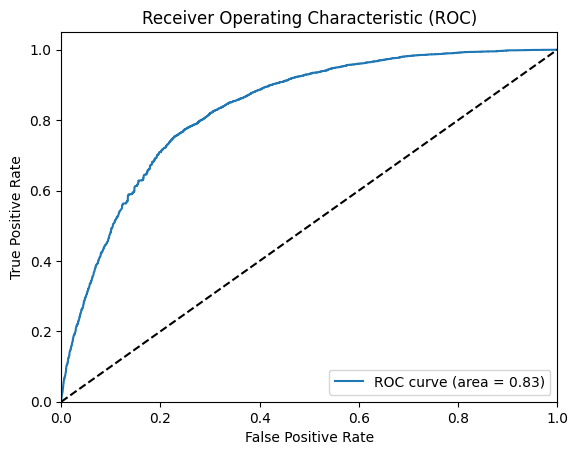

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)

# Calculate the area under the ROC curve (AUC)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

<class 'numpy.ndarray'>


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [ ]:
import numpy as np

# Given the coefficients and their confidence intervals from the model output
coefficients = {
    'const': -0.7019,
    'x1': -1.5120,
    'x2': -0.0061,
    'x3': -0.1063,
    'x4': -0.0389
}

ci_lower = {
    'const': -0.737,
    'x1': -1.550,
    'x2': -0.007,
    'x3': -0.110,
    'x4': -0.043
}

ci_upper = {
    'const': -0.666,
    'x1': -1.474,
    'x2': -0.006,
    'x3': -0.103,
    'x4': -0.035
}

# Calculate odds ratios and confidence intervals
odds_ratios = {feature: np.exp(coef) for feature, coef in coefficients.items()}
ci_odds_ratios = {
    feature: (np.exp(ci_lower[feature]), np.exp(ci_upper[feature]))
    for feature in coefficients
}

# Display odds ratios and their confidence intervals
print("\nOdds Ratios and Confidence Intervals:")
for feature in odds_ratios:
    print(f"Feature {feature}:")
    print(f"  Odds Ratio: {odds_ratios[feature]:.4f}")
    print(f"  95% CI: ({ci_odds_ratios[feature][0]:.4f}, {ci_odds_ratios[feature][1]:.4f})")

# Interpretation:
# - Odds ratios greater than 1 indicate an increase in the odds of the event occurring as the feature increases.
# - Odds ratios less than 1 indicate a decrease in the odds of the event occurring as the feature increases.
# - Confidence intervals around the odds ratios show the range within which the true value of the odds ratio is likely to fall with a certain level of confidence (typically 95%).



Odds Ratios and Confidence Intervals:
Feature const:
  Odds Ratio: 0.4956
  95% CI: (0.4785, 0.5138)
Feature x1:
  Odds Ratio: 0.2205
  95% CI: (0.2122, 0.2290)
Feature x2:
  Odds Ratio: 0.9939
  95% CI: (0.9930, 0.9940)
Feature x3:
  Odds Ratio: 0.8992
  95% CI: (0.8958, 0.9021)
Feature x4:
  Odds Ratio: 0.9618
  95% CI: (0.9579, 0.9656)


The results show that all features have odds ratios less than 1, indicating a decrease in the odds of the event occurring as each feature increases. The confidence intervals provide ranges for the odds ratios, confirming that these decreases are statistically significant.

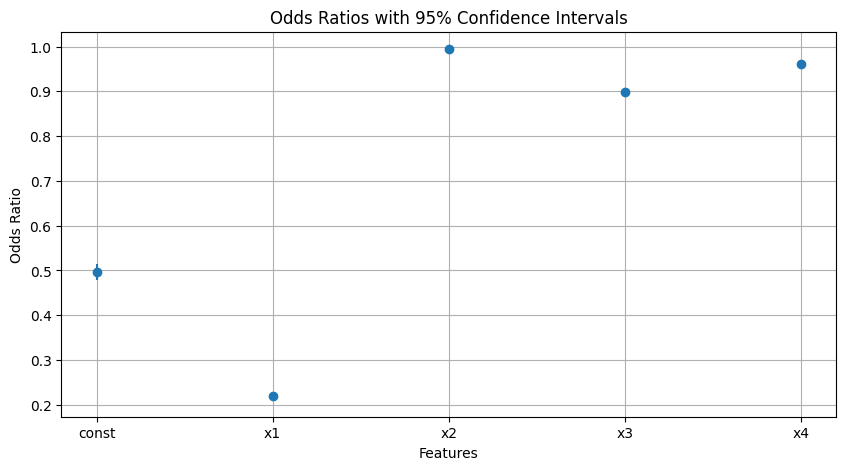

In [ ]:
import matplotlib.pyplot as plt

# Convert the dictionaries to lists for plotting
features = list(coefficients.keys())
odds_ratios_list = [odds_ratios[feature] for feature in features]
ci_lower_list = [ci_odds_ratios[feature][0] for feature in features]
ci_upper_list = [ci_odds_ratios[feature][1] for feature in features]

# Calculate the error values (distance from the odds ratio to the confidence interval bounds)
yerr_lower = [odds_ratios_list[i] - ci_lower_list[i] for i in range(len(features))]
yerr_upper = [ci_upper_list[i] - odds_ratios_list[i] for i in range(len(features))]

# Create the plot
plt.figure(figsize=(10, 5))
plt.errorbar(features, odds_ratios_list, yerr=[yerr_lower, yerr_upper], fmt='o')
plt.xlabel('Features')
plt.ylabel('Odds Ratio')
plt.title('Odds Ratios with 95% Confidence Intervals')
plt.grid(True)
plt.show()

/tmp/ipykernel_17236/1892687136.py:51: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

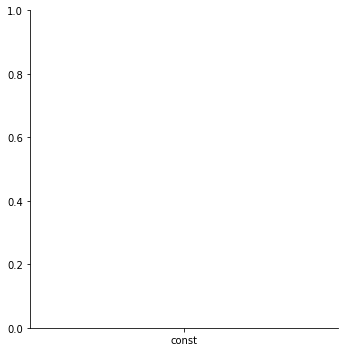

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Given the coefficients and their confidence intervals from the model output
coefficients = {
    'const': -0.7019,
    'x1': -1.5120,
    'x2': -0.0061,
    'x3': -0.1063,
    'x4': -0.0389
}

ci_lower = {
    'const': -0.737,
    'x1': -1.550,
    'x2': -0.007,
    'x3': -0.110,
    'x4': -0.043
}

ci_upper = {
    'const': -0.666,
    'x1': -1.474,
    'x2': -0.006,
    'x3': -0.103,
    'x4': -0.035
}

# Calculate odds ratios and confidence intervals
odds_ratios = {feature: np.exp(coef) for feature, coef in coefficients.items()}
ci_odds_ratios = {
    feature: (np.exp(ci_lower[feature]), np.exp(ci_upper[feature]))
    for feature in coefficients
}

# Convert the odds ratios and confidence intervals into a pandas DataFrame for plotting
data = {
    'Feature': list(odds_ratios.keys()),
    'Odds_Ratio': [odds_ratios[feature] for feature in odds_ratios],
    'CI_Lower': [ci_odds_ratios[feature][0] for feature in ci_odds_ratios],
    'CI_Upper': [ci_odds_ratios[feature][1] for feature in ci_odds_ratios]
}

df = pd.DataFrame(data)

df['Odds_Ratio'] = df['Odds_Ratio'].to_numpy()
df['Feature'] = df['Feature'].to_numpy()

sns.catplot(
    data=df,
    x='Feature',
    y='Odds_Ratio',
    kind='point',
    capsize=0.1,
    join=False,
    color='blue',
    markers='o',
)

# Convert pandas Series to numpy arrays before subtracting
yerr_lower = df['Odds_Ratio'].to_numpy() - df['CI_Lower'].to_numpy()
yerr_upper = df['CI_Upper'].to_numpy() - df['Odds_Ratio'].to_numpy()

plt.errorbar(
    df['Feature'],
    df['Odds_Ratio'],
    yerr=[yerr_lower, yerr_upper],
    fmt='none',
    color='red',
    capsize=3
)
# # Add error bars
# plt.errorbar(
#     df['Feature'],
#     df['Odds_Ratio'],
#     yerr=[df['Odds_Ratio'] - df['CI_Lower'], df['CI_Upper'] - df['Odds_Ratio']],
#     fmt='none',
#     color='red',
#     capsize=3
# )

# Add labels and title
plt.ylabel('Odds Ratios')
plt.title('Odds Ratios and 95% Confidence Intervals for Features')

# Show the plot
plt.show()
